This file represnet the baseline notebook.

In [11]:
import os
import shutil
import torch
import torch.nn as nn
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import timm
from utils import *

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define your classes
GENERAL_CLASSES = ['Fetal abdomen', 'Fetal brain', 'Fetal femur', 
                   'Fetal thorax', 'Maternal cervix', 'Other']
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(GENERAL_CLASSES)}


csv_path = 'FETAL_PLANES_DB_data.csv'
image_dir = './Images/'

Using device: cuda


In [13]:
def load_model(model_name, num_classes=6):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == 'efficientnet_b0':
        model = timm.create_model('efficientnet_b0', pretrained=True, in_chans=1, num_classes=num_classes)
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    return model


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


************* Densresnet18 *****************


100%|██████████| 44.7M/44.7M [00:06<00:00, 7.17MB/s]
Training Epoch 1/10: 100%|██████████| 446/446 [00:47<00:00,  9.45it/s]


Epoch 1, Loss: 0.4259
Test Accuracy: 0.8786

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.71      0.82      0.76       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.83      0.86      0.85       524
   Fetal thorax       0.72      0.96      0.82       660
Maternal cervix       0.97      0.98      0.97       645
          Other       0.90      0.72      0.80      1612

       accuracy                           0.88      5271
      macro avg       0.85      0.89      0.87      5271
   weighted avg       0.89      0.88      0.88      5271

Confusion Matrix:
 [[ 295    3    0   30    1   29]
 [   4 1455    2    5    0    6]
 [   0    0  453    4    1   66]
 [   3    0    0  634    1   22]
 [   2    0    0    2  635    6]
 [ 110   20   93  210   20 1159]]


Training Epoch 2/10: 100%|██████████| 446/446 [00:46<00:00,  9.67it/s]


Epoch 2, Loss: 0.2030
Test Accuracy: 0.8921

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.85      0.70      0.77       358
    Fetal brain       0.99      0.98      0.98      1472
    Fetal femur       0.90      0.76      0.82       524
   Fetal thorax       0.77      0.90      0.83       660
Maternal cervix       0.99      0.98      0.99       645
          Other       0.83      0.86      0.85      1612

       accuracy                           0.89      5271
      macro avg       0.89      0.86      0.87      5271
   weighted avg       0.90      0.89      0.89      5271

Confusion Matrix:
 [[ 251    2    0   42    0   63]
 [   3 1447    0    7    0   15]
 [   0    0  398    1    0  125]
 [   3    3    0  591    0   63]
 [   1    0    1    0  631   12]
 [  36   17   43  127    5 1384]]


Training Epoch 3/10: 100%|██████████| 446/446 [00:46<00:00,  9.68it/s]


Epoch 3, Loss: 0.1461
Test Accuracy: 0.8985

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.72      0.90      0.80       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.86      0.85      0.85       524
   Fetal thorax       0.83      0.87      0.85       660
Maternal cervix       0.98      1.00      0.99       645
          Other       0.88      0.80      0.84      1612

       accuracy                           0.90      5271
      macro avg       0.88      0.90      0.89      5271
   weighted avg       0.90      0.90      0.90      5271

Confusion Matrix:
 [[ 322    0    0    4    0   32]
 [   7 1455    0    4    0    6]
 [   1    0  444    4    0   75]
 [  13    2    0  575    0   70]
 [   1    0    0    0  644    0]
 [ 103   22   71  109   11 1296]]


Training Epoch 4/10: 100%|██████████| 446/446 [01:35<00:00,  4.67it/s]


Epoch 4, Loss: 0.1080
Test Accuracy: 0.9106

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.85      0.84      0.85       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.88      0.83      0.86       524
   Fetal thorax       0.85      0.90      0.88       660
Maternal cervix       0.96      0.99      0.98       645
          Other       0.87      0.85      0.86      1612

       accuracy                           0.91      5271
      macro avg       0.90      0.90      0.90      5271
   weighted avg       0.91      0.91      0.91      5271

Confusion Matrix:
 [[ 302    1    0    4    2   49]
 [   3 1457    0    0    0   12]
 [   0    0  437    0    0   87]
 [   3    2    0  593    0   62]
 [   1    0    1    1  641    1]
 [  46   20   57   96   23 1370]]


Training Epoch 5/10: 100%|██████████| 446/446 [01:35<00:00,  4.67it/s]


Epoch 5, Loss: 0.0866
Test Accuracy: 0.8814

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.57      0.96      0.71       358
    Fetal brain       0.97      0.99      0.98      1472
    Fetal femur       0.84      0.87      0.85       524
   Fetal thorax       0.87      0.87      0.87       660
Maternal cervix       0.98      0.99      0.99       645
          Other       0.90      0.73      0.80      1612

       accuracy                           0.88      5271
      macro avg       0.85      0.90      0.87      5271
   weighted avg       0.90      0.88      0.88      5271

Confusion Matrix:
 [[ 344    1    0    3    0   10]
 [   3 1462    0    1    0    6]
 [   4    1  457    0    0   62]
 [  31    5    0  572    0   52]
 [   4    0    0    2  638    1]
 [ 220   36   89   83   11 1173]]


Training Epoch 6/10: 100%|██████████| 446/446 [01:31<00:00,  4.85it/s]


Epoch 6, Loss: 0.0640
Test Accuracy: 0.9023

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.91      0.79      0.84       358
    Fetal brain       0.99      0.99      0.99      1472
    Fetal femur       0.78      0.93      0.85       524
   Fetal thorax       0.77      0.93      0.84       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.90      0.79      0.84      1612

       accuracy                           0.90      5271
      macro avg       0.89      0.90      0.89      5271
   weighted avg       0.91      0.90      0.90      5271

Confusion Matrix:
 [[ 283    1    0   16    0   58]
 [   2 1459    0    7    0    4]
 [   0    0  489    3    0   32]
 [   3    1    0  612    0   44]
 [   0    0    1    0  642    2]
 [  24   19  136  155    7 1271]]


Training Epoch 7/10: 100%|██████████| 446/446 [00:46<00:00,  9.53it/s]


Epoch 7, Loss: 0.0602
Test Accuracy: 0.9087

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.88      0.79      0.83       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.82      0.89      0.85       524
   Fetal thorax       0.80      0.93      0.86       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.90      0.82      0.86      1612

       accuracy                           0.91      5271
      macro avg       0.89      0.90      0.90      5271
   weighted avg       0.91      0.91      0.91      5271

Confusion Matrix:
 [[ 284    2    1   25    0   46]
 [   2 1459    0    4    0    7]
 [   0    0  466    1    0   57]
 [   3    1    1  613    0   42]
 [   1    0    0    0  644    0]
 [  33   23  103  122    7 1324]]


Training Epoch 8/10: 100%|██████████| 446/446 [00:46<00:00,  9.56it/s]


Epoch 8, Loss: 0.0599
Test Accuracy: 0.9023

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.78      0.94      0.85       358
    Fetal brain       0.97      0.99      0.98      1472
    Fetal femur       0.78      0.94      0.85       524
   Fetal thorax       0.83      0.93      0.88       660
Maternal cervix       0.97      1.00      0.99       645
          Other       0.94      0.75      0.83      1612

       accuracy                           0.90      5271
      macro avg       0.88      0.92      0.90      5271
   weighted avg       0.91      0.90      0.90      5271

Confusion Matrix:
 [[ 335    3    2    6    0   12]
 [   3 1461    1    1    0    6]
 [   2    1  491    0    0   30]
 [   8    1    0  615    0   36]
 [   1    0    0    0  644    0]
 [  82   41  139  122   18 1210]]


Training Epoch 9/10: 100%|██████████| 446/446 [00:45<00:00,  9.84it/s]


Epoch 9, Loss: 0.0595
Test Accuracy: 0.9190

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.84      0.88      0.86       358
    Fetal brain       0.97      0.99      0.98      1472
    Fetal femur       0.88      0.86      0.87       524
   Fetal thorax       0.86      0.91      0.89       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.90      0.85      0.87      1612

       accuracy                           0.92      5271
      macro avg       0.91      0.92      0.91      5271
   weighted avg       0.92      0.92      0.92      5271

Confusion Matrix:
 [[ 314    5    0    8    0   31]
 [   5 1458    0    1    0    8]
 [   0    1  452    1    0   70]
 [   5    3    0  601    0   51]
 [   1    0    0    0  644    0]
 [  47   37   62   84    7 1375]]


Training Epoch 10/10: 100%|██████████| 446/446 [00:46<00:00,  9.69it/s]


Epoch 10, Loss: 0.0402
Test Accuracy: 0.9179

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.81      0.89      0.85       358
    Fetal brain       0.99      0.98      0.99      1472
    Fetal femur       0.83      0.92      0.87       524
   Fetal thorax       0.91      0.85      0.88       660
Maternal cervix       0.98      1.00      0.99       645
          Other       0.88      0.86      0.87      1612

       accuracy                           0.92      5271
      macro avg       0.90      0.92      0.91      5271
   weighted avg       0.92      0.92      0.92      5271

Confusion Matrix:
 [[ 317    0    1    2    0   38]
 [  10 1444    0    0    0   18]
 [   2    0  482    0    0   40]
 [   9    0    0  564    0   87]
 [   1    0    0    0  644    0]
 [  51   11   97   55   11 1387]]


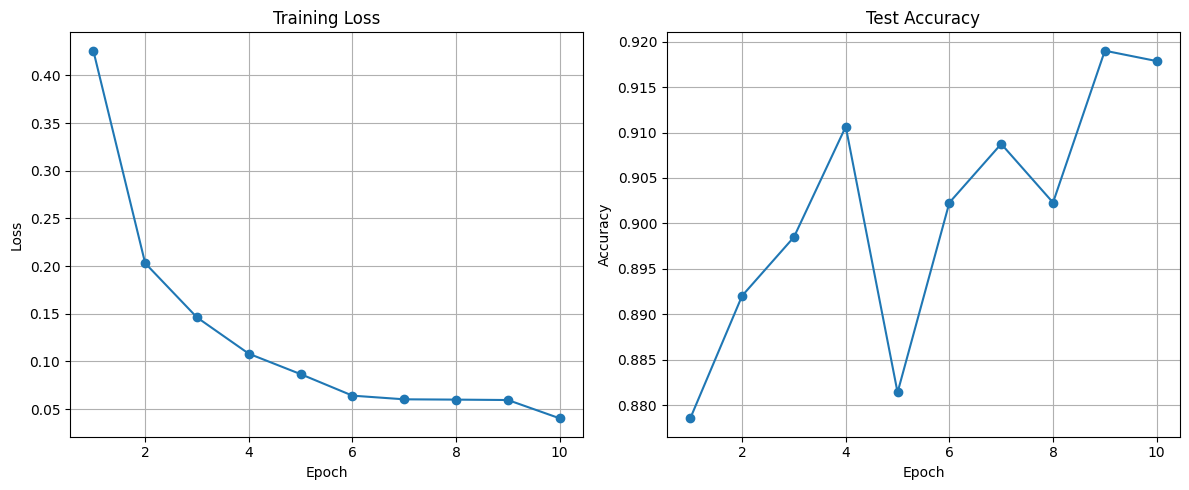

{5: {'loss': '0.0866', 'accuracy': '0.8814'}, 10: {'loss': '0.0402', 'accuracy': '0.9179'}}


In [14]:
#First run:
print("************* Densresnet18 *****************")
batch_size = 16
epochs = 8
lr = 1e-4
transform = transforms.Compose([#transformer 1
    transforms.Resize((128, 128)), #// original
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_loader, test_loader = load_data(csv_path, image_dir, batch_size, transform)

model = load_model("resnet18")
model = train(model, train_loader, test_loader, epochs=10, lr=1e-4)



************* Densresnet50 *****************


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:14<00:00, 6.89MB/s]
Training Epoch 1/10: 100%|██████████| 446/446 [00:57<00:00,  7.69it/s]


Epoch 1, Loss: 0.4579
Test Accuracy: 0.8828

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.92      0.53      0.67       358
    Fetal brain       0.99      0.98      0.98      1472
    Fetal femur       0.87      0.75      0.80       524
   Fetal thorax       0.88      0.87      0.87       660
Maternal cervix       0.99      0.93      0.96       645
          Other       0.77      0.90      0.83      1612

       accuracy                           0.88      5271
      macro avg       0.90      0.83      0.85      5271
   weighted avg       0.89      0.88      0.88      5271

Confusion Matrix:
 [[ 188    1    0    9    2  158]
 [   2 1440    1    4    0   25]
 [   0    1  392    0    0  131]
 [   3    2    0  572    0   83]
 [   1    0    0    2  603   39]
 [  11   16   60   62    5 1458]]


Training Epoch 2/10: 100%|██████████| 446/446 [00:57<00:00,  7.79it/s]


Epoch 2, Loss: 0.2022
Test Accuracy: 0.8974

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.78      0.88      0.83       358
    Fetal brain       0.98      0.99      0.98      1472
    Fetal femur       0.86      0.83      0.84       524
   Fetal thorax       0.82      0.86      0.84       660
Maternal cervix       1.00      0.97      0.98       645
          Other       0.85      0.83      0.84      1612

       accuracy                           0.90      5271
      macro avg       0.88      0.89      0.89      5271
   weighted avg       0.90      0.90      0.90      5271

Confusion Matrix:
 [[ 314    3    2   16    0   23]
 [   3 1452    0    3    0   14]
 [   0    0  434    0    0   90]
 [   3    1    1  566    0   89]
 [   1    0    2    2  628   12]
 [  82   23   67  101    3 1336]]


Training Epoch 3/10: 100%|██████████| 446/446 [00:56<00:00,  7.83it/s]


Epoch 3, Loss: 0.1564
Test Accuracy: 0.9036

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.83      0.89      0.86       358
    Fetal brain       0.98      0.99      0.98      1472
    Fetal femur       0.85      0.81      0.83       524
   Fetal thorax       0.77      0.98      0.86       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.90      0.79      0.84      1612

       accuracy                           0.90      5271
      macro avg       0.89      0.91      0.90      5271
   weighted avg       0.91      0.90      0.90      5271

Confusion Matrix:
 [[ 320    3    0    3    0   32]
 [   3 1460    2    2    0    5]
 [   0    1  427    3    0   93]
 [   5    1    0  647    0    7]
 [   1    0    0    0  642    2]
 [  55   30   72  182    6 1267]]


Training Epoch 4/10: 100%|██████████| 446/446 [00:57<00:00,  7.77it/s]


Epoch 4, Loss: 0.1203
Test Accuracy: 0.8964

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.87      0.77      0.82       358
    Fetal brain       0.99      0.98      0.99      1472
    Fetal femur       0.78      0.93      0.85       524
   Fetal thorax       0.85      0.80      0.83       660
Maternal cervix       0.98      1.00      0.99       645
          Other       0.84      0.83      0.84      1612

       accuracy                           0.90      5271
      macro avg       0.89      0.89      0.88      5271
   weighted avg       0.90      0.90      0.90      5271

Confusion Matrix:
 [[ 274    1    2    4    1   76]
 [   3 1449    4    1    0   15]
 [   0    1  487    1    0   35]
 [   3    0    3  529    0  125]
 [   1    0    0    0  643    1]
 [  33   14  125   87   10 1343]]


Training Epoch 5/10: 100%|██████████| 446/446 [00:57<00:00,  7.76it/s]


Epoch 5, Loss: 0.1120
Test Accuracy: 0.8983

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.76      0.93      0.84       358
    Fetal brain       0.98      0.99      0.98      1472
    Fetal femur       0.78      0.94      0.85       524
   Fetal thorax       0.79      0.95      0.86       660
Maternal cervix       0.99      0.98      0.98       645
          Other       0.94      0.75      0.83      1612

       accuracy                           0.90      5271
      macro avg       0.87      0.92      0.89      5271
   weighted avg       0.91      0.90      0.90      5271

Confusion Matrix:
 [[ 332    9    0   10    1    6]
 [   3 1451    2   11    0    5]
 [   1    1  492    1    0   29]
 [   2    0    0  628    0   30]
 [   1    0    1    3  631    9]
 [  97   27  135  147    5 1201]]


Training Epoch 6/10: 100%|██████████| 446/446 [00:57<00:00,  7.81it/s]


Epoch 6, Loss: 0.0815
Test Accuracy: 0.8989

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.75      0.92      0.83       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.75      0.93      0.83       524
   Fetal thorax       0.87      0.85      0.86       660
Maternal cervix       1.00      0.99      0.99       645
          Other       0.89      0.79      0.83      1612

       accuracy                           0.90      5271
      macro avg       0.87      0.91      0.89      5271
   weighted avg       0.90      0.90      0.90      5271

Confusion Matrix:
 [[ 330    0    1    4    0   23]
 [   4 1458    5    0    0    5]
 [   1    0  487    2    0   34]
 [  10    0    0  559    0   91]
 [   1    0    0    0  637    7]
 [  93   23  153   74    2 1267]]


Training Epoch 7/10: 100%|██████████| 446/446 [00:57<00:00,  7.79it/s]


Epoch 7, Loss: 0.0787
Test Accuracy: 0.9114

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.85      0.87      0.86       358
    Fetal brain       0.97      0.99      0.98      1472
    Fetal femur       0.86      0.89      0.87       524
   Fetal thorax       0.81      0.93      0.86       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.90      0.82      0.86      1612

       accuracy                           0.91      5271
      macro avg       0.90      0.91      0.90      5271
   weighted avg       0.91      0.91      0.91      5271

Confusion Matrix:
 [[ 312    2    0    2    0   42]
 [   3 1459    2    4    0    4]
 [   0    0  464    2    1   57]
 [   5    2    0  611    0   42]
 [   0    0    1    0  642    2]
 [  48   37   71  135    5 1316]]


Training Epoch 8/10: 100%|██████████| 446/446 [01:03<00:00,  7.06it/s]


Epoch 8, Loss: 0.0704
Test Accuracy: 0.9131

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.87      0.89      0.88       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.77      0.93      0.85       524
   Fetal thorax       0.83      0.93      0.88       660
Maternal cervix       1.00      0.99      0.99       645
          Other       0.92      0.80      0.86      1612

       accuracy                           0.91      5271
      macro avg       0.90      0.92      0.91      5271
   weighted avg       0.92      0.91      0.91      5271

Confusion Matrix:
 [[ 319    0    1    6    0   32]
 [   3 1455    4    1    0    9]
 [   0    1  488    1    0   34]
 [   4    1    1  614    0   40]
 [   1    0    0    1  641    2]
 [  40   22  137  114    3 1296]]


Training Epoch 9/10: 100%|██████████| 446/446 [00:56<00:00,  7.91it/s]


Epoch 9, Loss: 0.0548
Test Accuracy: 0.9139

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.88      0.80      0.84       358
    Fetal brain       0.98      0.99      0.98      1472
    Fetal femur       0.78      0.94      0.85       524
   Fetal thorax       0.85      0.93      0.89       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.90      0.82      0.86      1612

       accuracy                           0.91      5271
      macro avg       0.90      0.91      0.90      5271
   weighted avg       0.92      0.91      0.91      5271

Confusion Matrix:
 [[ 288    3    1    4    0   62]
 [   3 1452    5    1    1   10]
 [   0    1  494    0    0   29]
 [   4    3    1  614    0   38]
 [   1    0    1    0  642    1]
 [  30   19  130  101    5 1327]]


Training Epoch 10/10: 100%|██████████| 446/446 [00:56<00:00,  7.92it/s]


Epoch 10, Loss: 0.0606
Test Accuracy: 0.8968

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.68      0.96      0.80       358
    Fetal brain       0.98      0.99      0.98      1472
    Fetal femur       0.78      0.93      0.85       524
   Fetal thorax       0.82      0.94      0.88       660
Maternal cervix       0.98      1.00      0.99       645
          Other       0.94      0.73      0.82      1612

       accuracy                           0.90      5271
      macro avg       0.87      0.92      0.89      5271
   weighted avg       0.91      0.90      0.90      5271

Confusion Matrix:
 [[ 344    2    1    3    0    8]
 [   6 1452    3    2    0    9]
 [   3    2  485    0    2   32]
 [  16    0    0  620    0   24]
 [   1    0    0    0  642    2]
 [ 135   27  129  127   10 1184]]


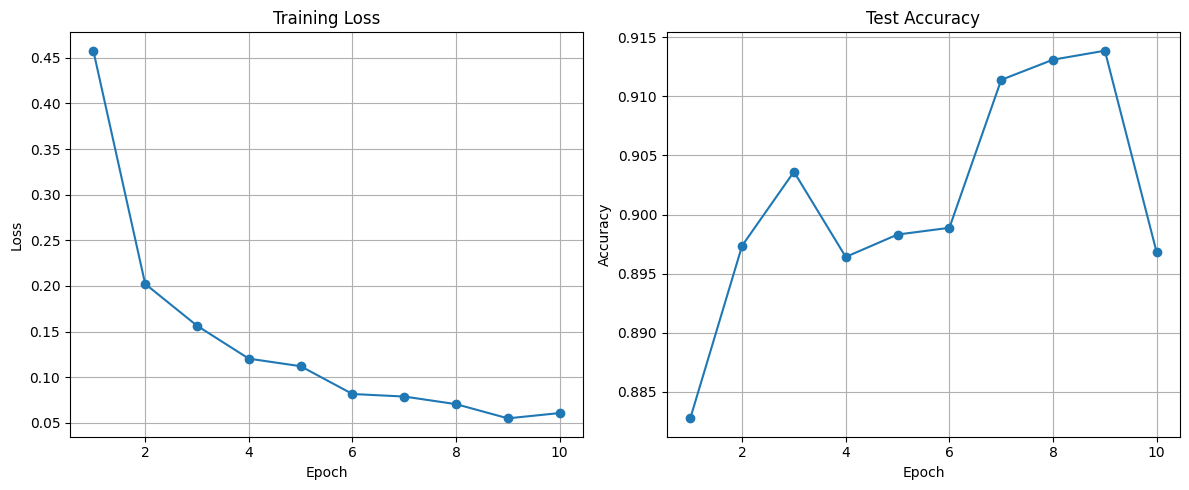

{5: {'loss': '0.1120', 'accuracy': '0.8983'}, 10: {'loss': '0.0606', 'accuracy': '0.8968'}}


In [15]:
#Second run:
print("************* Densresnet50 *****************")
batch_size = 16
epochs = 8
lr = 1e-4
transform = transforms.Compose([#transformer 1
    transforms.Resize((128, 128)), #// original
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_loader, test_loader = load_data(csv_path, image_dir, batch_size, transform)

model = load_model("resnet50")
model = train(model, train_loader, test_loader, epochs=10, lr=1e-4)



************* Densenet121 *****************


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:04<00:00, 7.16MB/s]
Training Epoch 1/10: 100%|██████████| 446/446 [00:58<00:00,  7.62it/s]


Epoch 1, Loss: 0.4570
Test Accuracy: 0.8960

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.72      0.87      0.79       358
    Fetal brain       0.99      0.99      0.99      1472
    Fetal femur       0.79      0.90      0.84       524
   Fetal thorax       0.84      0.90      0.87       660
Maternal cervix       0.97      1.00      0.99       645
          Other       0.89      0.77      0.83      1612

       accuracy                           0.90      5271
      macro avg       0.87      0.90      0.88      5271
   weighted avg       0.90      0.90      0.90      5271

Confusion Matrix:
 [[ 310    2    0    6    0   40]
 [   4 1456    0    2    1    9]
 [   0    0  473    1    1   49]
 [   9    0    2  594    0   55]
 [   1    0    0    0  644    0]
 [ 106   13  126  106   15 1246]]


Training Epoch 2/10: 100%|██████████| 446/446 [00:58<00:00,  7.58it/s]


Epoch 2, Loss: 0.2048
Test Accuracy: 0.9031

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.81      0.90      0.85       358
    Fetal brain       0.99      0.99      0.99      1472
    Fetal femur       0.84      0.90      0.87       524
   Fetal thorax       0.73      0.97      0.83       660
Maternal cervix       0.98      1.00      0.99       645
          Other       0.93      0.76      0.84      1612

       accuracy                           0.90      5271
      macro avg       0.88      0.92      0.90      5271
   weighted avg       0.91      0.90      0.90      5271

Confusion Matrix:
 [[ 322    0    0   21    0   15]
 [   7 1453    0   11    0    1]
 [   0    0  472    1    0   51]
 [   3    0    0  640    0   17]
 [   1    0    0    0  642    2]
 [  67   16   87  201   10 1231]]


Training Epoch 3/10: 100%|██████████| 446/446 [01:24<00:00,  5.30it/s]


Epoch 3, Loss: 0.1422
Test Accuracy: 0.9106

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.78      0.95      0.86       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.82      0.94      0.87       524
   Fetal thorax       0.80      0.95      0.87       660
Maternal cervix       0.98      1.00      0.99       645
          Other       0.94      0.77      0.85      1612

       accuracy                           0.91      5271
      macro avg       0.89      0.93      0.90      5271
   weighted avg       0.92      0.91      0.91      5271

Confusion Matrix:
 [[ 340    0    1    2    0   15]
 [   4 1463    3    1    0    1]
 [   0    0  491    2    0   31]
 [   6    0    0  625    0   29]
 [   1    0    1    0  642    1]
 [  83   26  103  148   13 1239]]


Training Epoch 4/10: 100%|██████████| 446/446 [01:46<00:00,  4.19it/s]


Epoch 4, Loss: 0.1069
Test Accuracy: 0.9158

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.83      0.91      0.87       358
    Fetal brain       0.99      0.99      0.99      1472
    Fetal femur       0.85      0.89      0.87       524
   Fetal thorax       0.85      0.88      0.87       660
Maternal cervix       0.97      1.00      0.98       645
          Other       0.89      0.84      0.86      1612

       accuracy                           0.92      5271
      macro avg       0.90      0.92      0.91      5271
   weighted avg       0.92      0.92      0.92      5271

Confusion Matrix:
 [[ 326    0    1    2    1   28]
 [   3 1459    3    1    0    6]
 [   0    0  464    0    0   60]
 [   4    1    0  581    0   74]
 [   1    0    0    0  644    0]
 [  57   11   76   96   19 1353]]


Training Epoch 5/10: 100%|██████████| 446/446 [02:05<00:00,  3.55it/s]


Epoch 5, Loss: 0.0831
Test Accuracy: 0.9154

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.82      0.93      0.87       358
    Fetal brain       0.99      0.99      0.99      1472
    Fetal femur       0.86      0.80      0.83       524
   Fetal thorax       0.86      0.93      0.89       660
Maternal cervix       0.98      0.99      0.99       645
          Other       0.89      0.84      0.86      1612

       accuracy                           0.92      5271
      macro avg       0.90      0.91      0.91      5271
   weighted avg       0.92      0.92      0.91      5271

Confusion Matrix:
 [[ 334    1    0    2    0   21]
 [   4 1462    1    1    0    4]
 [   1    0  420    0    0  103]
 [   3    0    0  612    0   45]
 [   1    0    1    0  640    3]
 [  66   18   65   95   11 1357]]


Training Epoch 6/10: 100%|██████████| 446/446 [02:29<00:00,  2.99it/s]


Epoch 6, Loss: 0.0730
Test Accuracy: 0.9209

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.84      0.88      0.86       358
    Fetal brain       0.98      1.00      0.99      1472
    Fetal femur       0.83      0.92      0.87       524
   Fetal thorax       0.89      0.89      0.89       660
Maternal cervix       0.99      0.99      0.99       645
          Other       0.90      0.85      0.87      1612

       accuracy                           0.92      5271
      macro avg       0.91      0.92      0.91      5271
   weighted avg       0.92      0.92      0.92      5271

Confusion Matrix:
 [[ 316    2    0    2    0   38]
 [   2 1465    0    0    0    5]
 [   0    0  480    0    0   44]
 [   6    2    0  587    0   65]
 [   1    0    0    0  640    4]
 [  53   22   95   67    9 1366]]


Training Epoch 7/10: 100%|██████████| 446/446 [01:48<00:00,  4.11it/s]


Epoch 7, Loss: 0.0615
Test Accuracy: 0.8994

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.87      0.89      0.88       358
    Fetal brain       0.99      0.99      0.99      1472
    Fetal femur       0.87      0.69      0.77       524
   Fetal thorax       0.92      0.77      0.84       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.80      0.90      0.85      1612

       accuracy                           0.90      5271
      macro avg       0.91      0.87      0.89      5271
   weighted avg       0.90      0.90      0.90      5271

Confusion Matrix:
 [[ 317    1    0    3    0   37]
 [   3 1458    0    2    0    9]
 [   0    0  361    0    0  163]
 [   2    0    0  508    0  150]
 [   1    0    0    0  642    2]
 [  42   15   56   38    6 1455]]


Training Epoch 8/10: 100%|██████████| 446/446 [02:23<00:00,  3.11it/s]


Epoch 8, Loss: 0.0570
Test Accuracy: 0.9228

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.85      0.93      0.89       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.83      0.93      0.88       524
   Fetal thorax       0.89      0.89      0.89       660
Maternal cervix       0.98      0.99      0.99       645
          Other       0.91      0.84      0.87      1612

       accuracy                           0.92      5271
      macro avg       0.91      0.93      0.92      5271
   weighted avg       0.92      0.92      0.92      5271

Confusion Matrix:
 [[ 333    0    0    0    0   25]
 [   4 1464    0    0    0    4]
 [   0    0  489    0    0   35]
 [   4    0    0  588    0   68]
 [   1    0    0    0  639    5]
 [  52   25   99   75   10 1351]]


Training Epoch 9/10: 100%|██████████| 446/446 [01:00<00:00,  7.36it/s]


Epoch 9, Loss: 0.0453
Test Accuracy: 0.9160

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.84      0.89      0.86       358
    Fetal brain       0.99      0.99      0.99      1472
    Fetal femur       0.86      0.84      0.85       524
   Fetal thorax       0.90      0.85      0.88       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.86      0.87      0.87      1612

       accuracy                           0.92      5271
      macro avg       0.91      0.91      0.91      5271
   weighted avg       0.92      0.92      0.92      5271

Confusion Matrix:
 [[ 318    0    1    0    1   38]
 [   5 1458    0    0    0    9]
 [   0    0  439    0    0   85]
 [   3    0    0  564    0   93]
 [   1    0    0    0  644    0]
 [  52   13   71   65    6 1405]]


Training Epoch 10/10: 100%|██████████| 446/446 [02:25<00:00,  3.07it/s]


Epoch 10, Loss: 0.0383
Test Accuracy: 0.9146

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.80      0.91      0.85       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.79      0.95      0.86       524
   Fetal thorax       0.86      0.93      0.89       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.93      0.79      0.86      1612

       accuracy                           0.91      5271
      macro avg       0.89      0.93      0.91      5271
   weighted avg       0.92      0.91      0.91      5271

Confusion Matrix:
 [[ 324    0    0    5    0   29]
 [   6 1463    0    0    1    2]
 [   0    1  497    2    0   24]
 [   3    0    1  614    0   42]
 [   1    0    0    0  643    1]
 [  72   28  133   95    4 1280]]


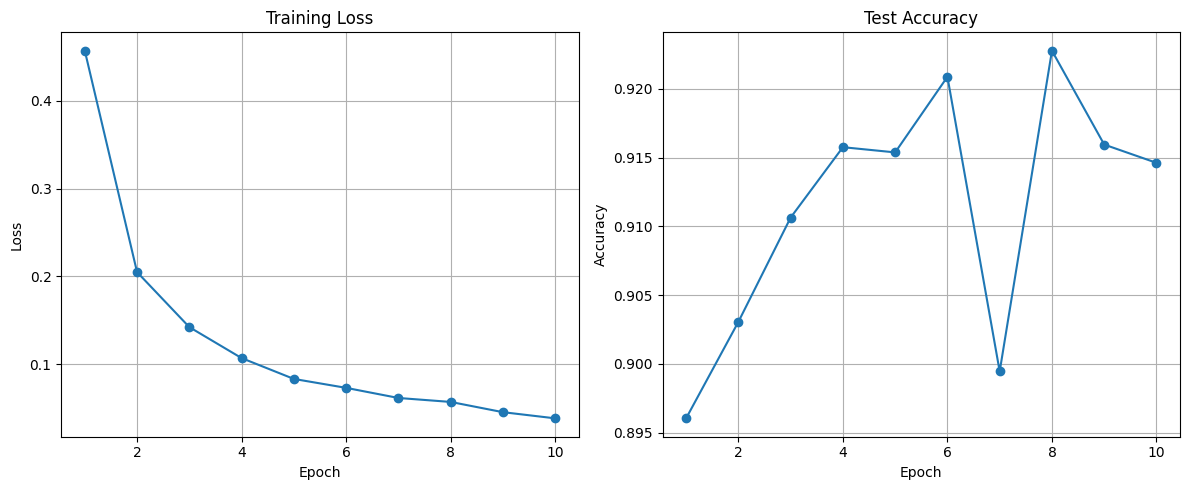

{5: {'loss': '0.0831', 'accuracy': '0.9154'}, 10: {'loss': '0.0383', 'accuracy': '0.9146'}}


In [16]:
#Second run:
print("************* Densenet121 *****************")
batch_size = 16
epochs = 8
lr = 1e-4
transform = transforms.Compose([#transformer 1
    transforms.Resize((128, 128)), #// original
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_loader, test_loader = load_data(csv_path, image_dir, batch_size, transform)

model = load_model("densenet121")
model = train(model, train_loader, test_loader, epochs=10, lr=1e-4)



************* Efficientnet_b0 *****************


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Training Epoch 1/10: 100%|██████████| 446/446 [01:56<00:00,  3.83it/s]


Epoch 1, Loss: 0.8462
Test Accuracy: 0.8336

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.59      0.74      0.66       358
    Fetal brain       0.96      0.97      0.97      1472
    Fetal femur       0.69      0.84      0.76       524
   Fetal thorax       0.70      0.83      0.76       660
Maternal cervix       0.97      0.99      0.98       645
          Other       0.86      0.67      0.75      1612

       accuracy                           0.83      5271
      macro avg       0.79      0.84      0.81      5271
   weighted avg       0.85      0.83      0.83      5271

Confusion Matrix:
 [[ 266    6    6   45    0   35]
 [  11 1429    4   19    2    7]
 [   6    5  439    7    0   67]
 [  30    7    5  549    1   68]
 [   2    1    3    1  636    2]
 [ 137   37  179  165   19 1075]]


Training Epoch 2/10: 100%|██████████| 446/446 [01:56<00:00,  3.81it/s]


Epoch 2, Loss: 0.2663
Test Accuracy: 0.8581

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.74      0.74      0.74       358
    Fetal brain       0.98      0.96      0.97      1472
    Fetal femur       0.73      0.81      0.77       524
   Fetal thorax       0.70      0.87      0.78       660
Maternal cervix       0.99      0.98      0.98       645
          Other       0.85      0.75      0.80      1612

       accuracy                           0.86      5271
      macro avg       0.83      0.85      0.84      5271
   weighted avg       0.86      0.86      0.86      5271

Confusion Matrix:
 [[ 264    2    4   54    1   33]
 [   5 1420    5   27    2   13]
 [   1    3  424    5    1   90]
 [   7    4    1  576    0   72]
 [   1    1    2    2  634    5]
 [  77   19  148  158    5 1205]]


Training Epoch 3/10: 100%|██████████| 446/446 [01:35<00:00,  4.65it/s]


Epoch 3, Loss: 0.1551
Test Accuracy: 0.8788

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.67      0.80      0.73       358
    Fetal brain       0.98      0.97      0.98      1472
    Fetal femur       0.78      0.87      0.82       524
   Fetal thorax       0.80      0.85      0.82       660
Maternal cervix       0.99      0.99      0.99       645
          Other       0.87      0.78      0.82      1612

       accuracy                           0.88      5271
      macro avg       0.85      0.88      0.86      5271
   weighted avg       0.88      0.88      0.88      5271

Confusion Matrix:
 [[ 286    1    1   29    0   41]
 [   9 1430    3   18    0   12]
 [   2    2  454    4    1   61]
 [  18    4    2  559    0   77]
 [   1    0    0    0  641    3]
 [ 108   23  120   92    7 1262]]


Training Epoch 4/10: 100%|██████████| 446/446 [01:56<00:00,  3.82it/s]


Epoch 4, Loss: 0.1094
Test Accuracy: 0.8888

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.81      0.78      0.80       358
    Fetal brain       0.96      0.99      0.98      1472
    Fetal femur       0.75      0.88      0.81       524
   Fetal thorax       0.81      0.89      0.85       660
Maternal cervix       0.98      0.99      0.99       645
          Other       0.88      0.78      0.83      1612

       accuracy                           0.89      5271
      macro avg       0.87      0.89      0.88      5271
   weighted avg       0.89      0.89      0.89      5271

Confusion Matrix:
 [[ 279    4    2   25    0   48]
 [   4 1453    3    5    1    6]
 [   1    3  459    0    0   61]
 [   6    6    2  590    1   55]
 [   0    1    0    0  639    5]
 [  53   40  142  104    8 1265]]


Training Epoch 5/10: 100%|██████████| 446/446 [01:58<00:00,  3.77it/s]


Epoch 5, Loss: 0.0772
Test Accuracy: 0.8843

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.76      0.81      0.79       358
    Fetal brain       0.97      0.99      0.98      1472
    Fetal femur       0.75      0.87      0.81       524
   Fetal thorax       0.78      0.93      0.85       660
Maternal cervix       0.99      0.99      0.99       645
          Other       0.89      0.75      0.81      1612

       accuracy                           0.88      5271
      macro avg       0.86      0.89      0.87      5271
   weighted avg       0.89      0.88      0.88      5271

Confusion Matrix:
 [[ 290    3    1   28    0   36]
 [   4 1452    4    6    0    6]
 [   1    0  456    0    0   67]
 [   5    3    0  615    0   37]
 [   1    0    1    0  640    3]
 [  79   37  142  137    9 1208]]


Training Epoch 6/10: 100%|██████████| 446/446 [02:01<00:00,  3.66it/s]


Epoch 6, Loss: 0.0671
Test Accuracy: 0.8847

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.77      0.81      0.79       358
    Fetal brain       0.98      0.99      0.98      1472
    Fetal femur       0.70      0.94      0.81       524
   Fetal thorax       0.85      0.86      0.86       660
Maternal cervix       0.99      0.98      0.99       645
          Other       0.87      0.76      0.82      1612

       accuracy                           0.88      5271
      macro avg       0.86      0.89      0.87      5271
   weighted avg       0.89      0.88      0.88      5271

Confusion Matrix:
 [[ 290    3    5   14    0   46]
 [   4 1450    2    3    0   13]
 [   1    0  494    1    0   28]
 [   9    6    1  568    0   76]
 [   0    0    1    1  630   13]
 [  73   24  199   81    4 1231]]


Training Epoch 7/10: 100%|██████████| 446/446 [01:58<00:00,  3.75it/s]


Epoch 7, Loss: 0.0621
Test Accuracy: 0.8869

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.83      0.79      0.81       358
    Fetal brain       0.98      0.98      0.98      1472
    Fetal femur       0.76      0.87      0.81       524
   Fetal thorax       0.75      0.91      0.82       660
Maternal cervix       0.99      0.99      0.99       645
          Other       0.89      0.78      0.83      1612

       accuracy                           0.89      5271
      macro avg       0.87      0.89      0.87      5271
   weighted avg       0.89      0.89      0.89      5271

Confusion Matrix:
 [[ 283    2    3   38    0   32]
 [   3 1436    3   22    1    7]
 [   0    2  458    1    0   63]
 [   6    1    2  598    0   53]
 [   1    0    3    1  636    4]
 [  49   23  133  139    4 1264]]


Training Epoch 8/10: 100%|██████████| 446/446 [01:57<00:00,  3.80it/s]


Epoch 8, Loss: 0.0413
Test Accuracy: 0.8896

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.84      0.70      0.76       358
    Fetal brain       0.98      0.98      0.98      1472
    Fetal femur       0.75      0.92      0.83       524
   Fetal thorax       0.78      0.92      0.85       660
Maternal cervix       0.99      0.99      0.99       645
          Other       0.88      0.78      0.83      1612

       accuracy                           0.89      5271
      macro avg       0.87      0.88      0.87      5271
   weighted avg       0.89      0.89      0.89      5271

Confusion Matrix:
 [[ 250    0    2   26    0   80]
 [   3 1447    2   12    0    8]
 [   1    2  483    0    0   38]
 [   2    1    0  606    0   51]
 [   0    0    0    2  641    2]
 [  43   23  153  126    5 1262]]


Training Epoch 9/10: 100%|██████████| 446/446 [01:56<00:00,  3.84it/s]


Epoch 9, Loss: 0.0401
Test Accuracy: 0.9015

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.77      0.81      0.79       358
    Fetal brain       0.98      0.98      0.98      1472
    Fetal femur       0.78      0.88      0.83       524
   Fetal thorax       0.87      0.90      0.89       660
Maternal cervix       0.99      0.99      0.99       645
          Other       0.89      0.82      0.85      1612

       accuracy                           0.90      5271
      macro avg       0.88      0.90      0.89      5271
   weighted avg       0.90      0.90      0.90      5271

Confusion Matrix:
 [[ 289    5    3   10    1   50]
 [   3 1447    6    5    0   11]
 [   0    1  463    1    0   59]
 [   8    4    3  596    0   49]
 [   0    0    0    2  641    2]
 [  73   27  122   70    4 1316]]


Training Epoch 10/10: 100%|██████████| 446/446 [01:57<00:00,  3.78it/s]


Epoch 10, Loss: 0.0372
Test Accuracy: 0.9051

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.77      0.83      0.80       358
    Fetal brain       0.98      0.99      0.98      1472
    Fetal femur       0.81      0.90      0.85       524
   Fetal thorax       0.86      0.90      0.87       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.89      0.82      0.85      1612

       accuracy                           0.91      5271
      macro avg       0.88      0.90      0.89      5271
   weighted avg       0.91      0.91      0.91      5271

Confusion Matrix:
 [[ 297    2    3   16    0   40]
 [   5 1451    2    5    0    9]
 [   1    2  470    1    0   50]
 [   3    1    0  591    0   65]
 [   0    0    0    1  642    2]
 [  78   25  105   77    7 1320]]


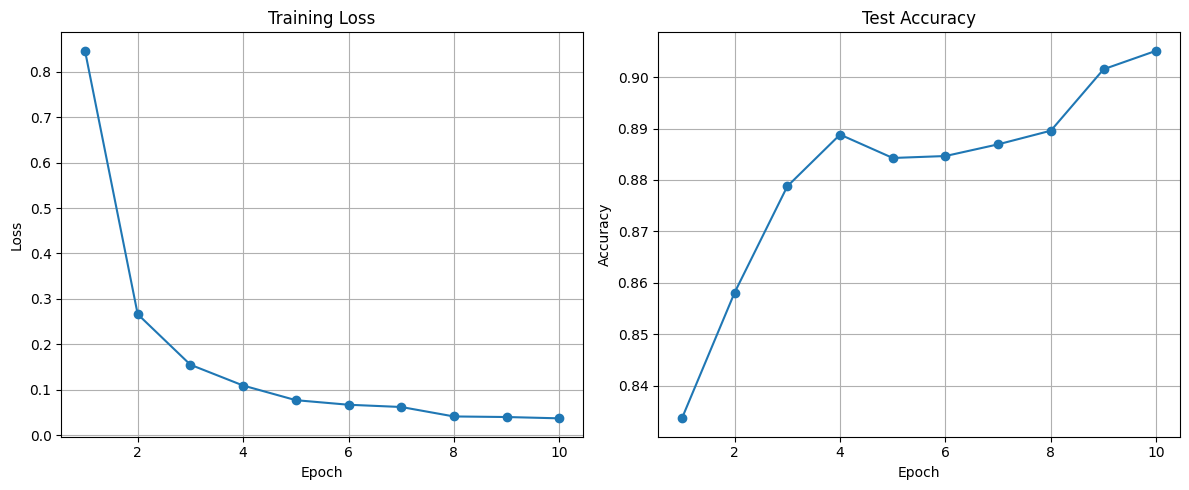

{5: {'loss': '0.0772', 'accuracy': '0.8843'}, 10: {'loss': '0.0372', 'accuracy': '0.9051'}}


In [17]:
#Second run:
print("************* Efficientnet_b0 *****************")
batch_size = 16
epochs = 8
lr = 1e-4
transform = transforms.Compose([#transformer 1
    transforms.Resize((128, 128)), #// original
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_loader, test_loader = load_data(csv_path, image_dir, batch_size, transform)

model = load_model("efficientnet_b0")
model = train(model, train_loader, test_loader, epochs=10, lr=1e-4)



************* Mobilenet_v2 *****************


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 7.17MB/s]
Training Epoch 1/10: 100%|██████████| 446/446 [01:52<00:00,  3.97it/s]


Epoch 1, Loss: 0.4419
Test Accuracy: 0.8938

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.81      0.73      0.77       358
    Fetal brain       0.98      0.99      0.98      1472
    Fetal femur       0.84      0.77      0.80       524
   Fetal thorax       0.82      0.92      0.86       660
Maternal cervix       0.98      0.98      0.98       645
          Other       0.85      0.84      0.84      1612

       accuracy                           0.89      5271
      macro avg       0.88      0.87      0.87      5271
   weighted avg       0.89      0.89      0.89      5271

Confusion Matrix:
 [[ 262    8    1   19    1   67]
 [   4 1450    1    4    0   13]
 [   1    1  403    1    0  118]
 [   5    3    1  608    0   43]
 [   2    1    0    2  635    5]
 [  48   18   72  112    9 1353]]


Training Epoch 2/10: 100%|██████████| 446/446 [01:46<00:00,  4.18it/s]


Epoch 2, Loss: 0.2192
Test Accuracy: 0.9036

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.74      0.91      0.82       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.79      0.92      0.85       524
   Fetal thorax       0.85      0.89      0.87       660
Maternal cervix       0.98      1.00      0.99       645
          Other       0.91      0.79      0.84      1612

       accuracy                           0.90      5271
      macro avg       0.88      0.91      0.89      5271
   weighted avg       0.91      0.90      0.90      5271

Confusion Matrix:
 [[ 324    1    1   17    0   15]
 [   5 1458    1    2    0    6]
 [   0    2  480    0    0   42]
 [   7    1    1  590    0   61]
 [   1    0    0    0  643    1]
 [ 100   23  126   84   11 1268]]


Training Epoch 3/10: 100%|██████████| 446/446 [00:45<00:00,  9.83it/s]


Epoch 3, Loss: 0.1715
Test Accuracy: 0.8983

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.75      0.91      0.82       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.80      0.81      0.80       524
   Fetal thorax       0.86      0.88      0.87       660
Maternal cervix       0.99      1.00      0.99       645
          Other       0.87      0.81      0.84      1612

       accuracy                           0.90      5271
      macro avg       0.88      0.90      0.89      5271
   weighted avg       0.90      0.90      0.90      5271

Confusion Matrix:
 [[ 324    0    0    5    0   29]
 [   3 1460    0    1    0    8]
 [   0    1  425    2    0   96]
 [  15    1    0  582    0   62]
 [   1    0    0    0  643    1]
 [  90   23  108   84    6 1301]]


Training Epoch 4/10: 100%|██████████| 446/446 [00:45<00:00,  9.70it/s]


Epoch 4, Loss: 0.1328
Test Accuracy: 0.9072

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.77      0.91      0.84       358
    Fetal brain       0.98      0.99      0.99      1472
    Fetal femur       0.81      0.90      0.86       524
   Fetal thorax       0.85      0.94      0.89       660
Maternal cervix       0.95      0.99      0.97       645
          Other       0.92      0.78      0.84      1612

       accuracy                           0.91      5271
      macro avg       0.88      0.92      0.90      5271
   weighted avg       0.91      0.91      0.91      5271

Confusion Matrix:
 [[ 327    0    1    7    2   21]
 [   3 1464    1    2    0    2]
 [   0    0  472    1    1   50]
 [   4    2    0  621    0   33]
 [   1    0    0    0  641    3]
 [  89   26  106  103   31 1257]]


Training Epoch 5/10: 100%|██████████| 446/446 [00:44<00:00, 10.02it/s]


Epoch 5, Loss: 0.1094
Test Accuracy: 0.9072

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.70      0.95      0.80       358
    Fetal brain       0.99      0.99      0.99      1472
    Fetal femur       0.81      0.94      0.87       524
   Fetal thorax       0.84      0.93      0.88       660
Maternal cervix       0.98      0.99      0.98       645
          Other       0.94      0.77      0.85      1612

       accuracy                           0.91      5271
      macro avg       0.88      0.93      0.90      5271
   weighted avg       0.92      0.91      0.91      5271

Confusion Matrix:
 [[ 340    0    1    8    0    9]
 [   4 1461    2    4    0    1]
 [   1    0  493    1    0   29]
 [  13    0    0  614    0   33]
 [   3    0    1    1  640    0]
 [ 126   18  115  103   16 1234]]


Training Epoch 6/10: 100%|██████████| 446/446 [00:47<00:00,  9.37it/s]


Epoch 6, Loss: 0.0918
Test Accuracy: 0.9122

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.75      0.92      0.83       358
    Fetal brain       0.99      0.98      0.98      1472
    Fetal femur       0.83      0.92      0.87       524
   Fetal thorax       0.88      0.89      0.89       660
Maternal cervix       0.98      0.99      0.99       645
          Other       0.91      0.82      0.86      1612

       accuracy                           0.91      5271
      macro avg       0.89      0.92      0.90      5271
   weighted avg       0.92      0.91      0.91      5271

Confusion Matrix:
 [[ 331    0    0   10    1   16]
 [   7 1443    0    3    1   18]
 [   0    0  483    1    0   40]
 [   8    0    1  590    0   61]
 [   1    0    0    0  641    3]
 [  93   18  101   68   12 1320]]


Training Epoch 7/10: 100%|██████████| 446/446 [00:45<00:00,  9.83it/s]


Epoch 7, Loss: 0.0692
Test Accuracy: 0.8977

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.76      0.92      0.83       358
    Fetal brain       0.97      0.99      0.98      1472
    Fetal femur       0.72      0.96      0.82       524
   Fetal thorax       0.86      0.93      0.89       660
Maternal cervix       0.98      0.99      0.99       645
          Other       0.93      0.73      0.82      1612

       accuracy                           0.90      5271
      macro avg       0.87      0.92      0.89      5271
   weighted avg       0.91      0.90      0.90      5271

Confusion Matrix:
 [[ 331    2    2    4    0   19]
 [   5 1460    1    0    1    5]
 [   0    1  501    0    0   22]
 [   9    2    1  615    0   33]
 [   0    0    0    0  641    4]
 [  93   37  187  100   11 1184]]


Training Epoch 8/10: 100%|██████████| 446/446 [00:44<00:00,  9.93it/s]


Epoch 8, Loss: 0.0729
Test Accuracy: 0.9139

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.78      0.90      0.84       358
    Fetal brain       0.99      0.99      0.99      1472
    Fetal femur       0.86      0.87      0.86       524
   Fetal thorax       0.85      0.92      0.88       660
Maternal cervix       0.98      0.99      0.99       645
          Other       0.90      0.83      0.86      1612

       accuracy                           0.91      5271
      macro avg       0.89      0.92      0.90      5271
   weighted avg       0.92      0.91      0.91      5271

Confusion Matrix:
 [[ 322    0    0    7    0   29]
 [   3 1458    0    3    1    7]
 [   0    0  454    3    1   66]
 [   4    0    0  606    0   50]
 [   0    0    0    3  639    3]
 [  83   18   76   89    8 1338]]


Training Epoch 9/10: 100%|██████████| 446/446 [00:45<00:00,  9.77it/s]


Epoch 9, Loss: 0.0643
Test Accuracy: 0.9097

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.73      0.91      0.81       358
    Fetal brain       0.97      1.00      0.98      1472
    Fetal femur       0.84      0.90      0.87       524
   Fetal thorax       0.89      0.88      0.89       660
Maternal cervix       0.98      1.00      0.99       645
          Other       0.90      0.81      0.85      1612

       accuracy                           0.91      5271
      macro avg       0.89      0.92      0.90      5271
   weighted avg       0.91      0.91      0.91      5271

Confusion Matrix:
 [[ 327    2    0    2    1   26]
 [   4 1465    0    1    0    2]
 [   0    1  474    0    0   49]
 [  14    3    0  583    0   60]
 [   1    0    0    0  643    1]
 [ 104   33   88   70   14 1303]]


Training Epoch 10/10: 100%|██████████| 446/446 [00:45<00:00,  9.71it/s]


Epoch 10, Loss: 0.0510
Test Accuracy: 0.9089

Classification Report:
                 precision    recall  f1-score   support

  Fetal abdomen       0.82      0.87      0.84       358
    Fetal brain       0.98      0.99      0.98      1472
    Fetal femur       0.83      0.89      0.86       524
   Fetal thorax       0.82      0.92      0.87       660
Maternal cervix       0.98      0.99      0.99       645
          Other       0.90      0.81      0.86      1612

       accuracy                           0.91      5271
      macro avg       0.89      0.91      0.90      5271
   weighted avg       0.91      0.91      0.91      5271

Confusion Matrix:
 [[ 310    1    0   15    0   32]
 [   4 1456    1    1    0   10]
 [   0    0  465    5    0   54]
 [   6    1    0  607    0   46]
 [   1    0    0    0  641    3]
 [  55   31   96  108   10 1312]]


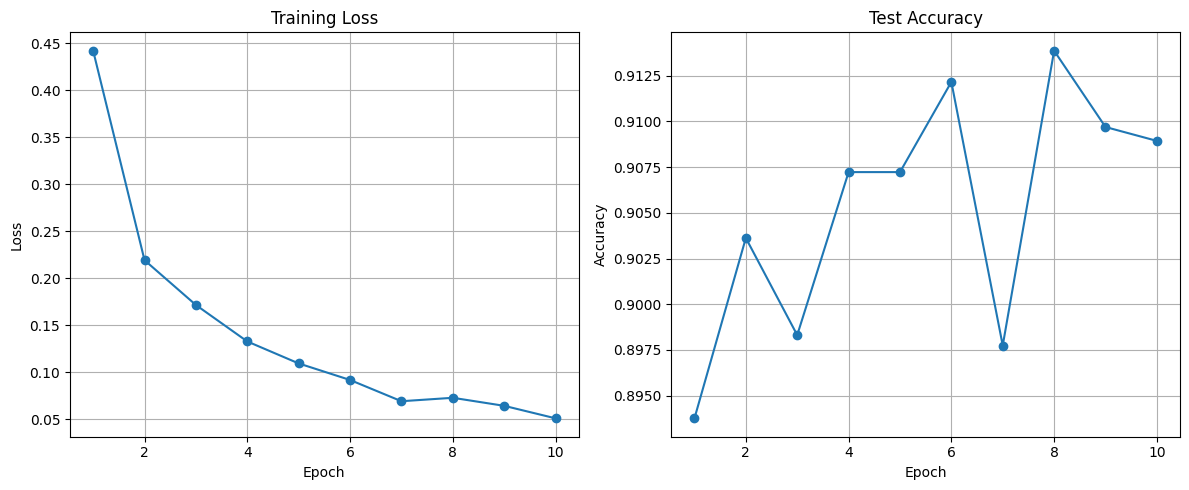

{5: {'loss': '0.1094', 'accuracy': '0.9072'}, 10: {'loss': '0.0510', 'accuracy': '0.9089'}}


In [18]:
#Second run:
print("************* Mobilenet_v2 *****************")
batch_size = 16
epochs = 8
lr = 1e-4
transform = transforms.Compose([#transformer 1
    transforms.Resize((128, 128)), #// original
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_loader, test_loader = load_data(csv_path, image_dir, batch_size, transform)

model = load_model("mobilenet_v2")
model = train(model, train_loader, test_loader, epochs=10, lr=1e-4)

